### Manipulator Jacobians

This Notebook gives examples of computations with the Jacobian.

This Notebook uses a couple of packages...

import Pkg ; Pkg.add("NLsolve")

In [2]:
using LinearAlgebra
using NLsolve
using Plots

We begin with the Two Link manipulator.  The forward kinematics is 

In [3]:
function FK(θ1, θ2, a1, a2)
    x = a2*cos(θ1+θ2) + a1*cos(θ1)
    y = a2*sin(θ1+θ2) + a1*sin(θ1)
    return x,y
end

FK (generic function with 1 method)

And the Jacobian is 

In [4]:
function FKJ(θ1, θ2, a1, a2)
    j11 = -a2*sin(θ1+θ2) - a1*sin(θ1)
    j12 = -a2*sin(θ1+θ2)
    j21 = a2*cos(θ1+θ2) + a1*cos(θ1)
    j22 = a2*cos(θ1+θ2)
    J = [ j11 j12 ; j21 j22]
    return J
end

FKJ (generic function with 1 method)

We can see how this works by a simple command:

In [5]:
J = FKJ(0.1, 0.2, 10, 10)

2×2 Matrix{Float64}:
 -3.95354  -2.9552
 19.5034    9.55336

If joint velocities are [5,10], then the manipulator velocity is

In [6]:
qdot = [5,10]
v = J*qdot

2-element Vector{Float64}:
 -49.319701831542346
 193.05068163274217

We can extract the joint velocity from the linear velocity

In [7]:
inv(J)*v

2-element Vector{Float64}:
  5.0
 10.0

We can numerically extract the inverse kinematics.  First a couple of measurement functions

In [8]:
function distance(x1, y1, x2, y2)
    d = sqrt((x1-x2)^2 + (y1-y2)^2)
    return d
end

function size(v1,v2)
    size = sqrt(v1*v1+v2*v2)
    return size
end

size (generic function with 1 method)

Then we can implement the algorithm in the text:

In [9]:
x = 10
y = 12
θ1 = 0.1
θ2 = 0.2
a1 = a2 = 10
δ, k = 0.1, 0
xc, yc = FK(θ1, θ2, a1, a2)
d = distance(x, y, xc, yc)

while d > .001
    vx = x - xc
    vy = y - yc
    s = δ*size(vx, vy)
    ux = s*vx
    uy = s*vy
    J = FKJ(θ1, θ2, a1, a2)
    u = [ux, uy]
    w = J\u
    θ1 = θ1 + w[1]
    θ2 = θ2 + w[2]
    xc, yc = FK(θ1, θ2, a1, a2)
    d = distance(x, y, xc, yc)
    k += 1
end
θ1 = θ1 - 2*π*trunc(θ1/(2*π))
θ2 = θ2 - 2*π*trunc(θ2/(2*π))
println("k = ", k, " :  θ1 = ", θ1, ",   θ2 = ", θ2, ",  x = ", xc, ",  y = ", yc)

k = 9991 :  θ1 = -4.7325598383486085,   θ2 = 4.934176707104502,  x = 9.999135648651585,  y = 12.00050284587803


This works, but is really slow (convergence) so we try a Newton based algorithm.  It also needs the Jacobian.  The NLsolve package solves systems of nonlinear equations. Formally, if F is a multivalued function, then this package looks for some vector x that satisfies F(x)=0 to some accuracy.   Using the NLsolve package it is a simple rewrite:

In [10]:
function f!(F, x)
    F[1] = 10*cos(x[1]+x[2]) + 10*cos(x[1]) - 10
    F[2] = 10*sin(x[1]+x[2]) + 10*sin(x[1]) - 12
end


function j!(J, x)
    J[1, 1] = -10*sin(x[1]+x[2]) - 10*sin(x[1])
    J[1, 2] = -10*sin(x[1]+x[2])
    J[2, 1] = 10*cos(x[1]+x[2]) + 10*cos(x[1])
    J[2, 2] = 10*cos(x[1]+x[2])
end

res = nlsolve(f!, j!, [ 0.5; 0.2])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.5, 0.2]
 * Zero: [0.20156712244914232, 1.3489818562981022]
 * Inf-norm of residuals: 0.000000
 * Iterations: 5
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 6
 * Jacobian Calls (df/dx): 6

What is up with the "!".  This is a Julia convention to indicate that the function modifies its arguments but does not affect the function semantics otherwise.   Numerical solutions to equations is a whole subject and we will move on for now.

How about a simple extension to the three link manipulator?  In the following cells we try the same approach.

In [31]:
function threelink!(F, x)
    a1 = 10
    a2 = 10
    a3 = 10
    F[1] = a3*cos(x[1] + x[2] + x[3]) + a2*cos(x[1] + x[2]) + a1*cos(x[1])
    F[2] = a3*sin(x[1] + x[2] + x[3]) + a2*sin(x[1] + x[2]) + a1*sin(x[1])
    return F
end

function f!(F, x)
    G = threelink!(F, x)
    F[1] = G[1]-20
    F[2] = G[2]-25
    return F
end

f! (generic function with 1 method)

In [32]:
function j!(J,x)
  a1 = 10
  a2 = 10
  a3 = 10
  J[1,1] = -a3*sin(x[1] + x[2] + x[3])- a2*sin(x[1] + x[2]) - a1*sin(x[1]) 
  J[1,2] = -a3*sin(x[1] + x[2] + x[3])- a2*sin(x[1] + x[2])  
  J[1,3] = -a3*sin(x[1] + x[2] + x[3])
  J[2,1] =  a3*cos(x[1] + x[2] + x[3])+ a2*cos(x[1] + x[2]) + a1*cos(x[1]) 
  J[2,2] =  a3*cos(x[1] + x[2] + x[3])+ a2*cos(x[1] + x[2])  
  J[2,3] =  a3*cos(x[1] + x[2] + x[3]) 
  return J
end

j! (generic function with 1 method)

In [33]:
res = nlsolve(f!, j!, [ 0.1; 0.2; 0.3])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.1, 0.2, 0.3]
 * Zero: [NaN, NaN, NaN]
 * Inf-norm of residuals: 15.400039
 * Iterations: 1
 * Convergence: false
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: false
 * Function Calls (f): 2
 * Jacobian Calls (df/dx): 1

What went wrong?  (The other algorithm fails also.)

The problem is that the Jacobian is not square and so not invertable.  

In [34]:
J = zeros(2,3)
x = zeros(3)
x[1] = 0.1
x[2] = 0.2
x[3] = 0.3
J = j!(J,x)

2×3 Matrix{Float64}:
 -9.59996  -8.60163  -5.64642
 27.7568   17.8067    8.25336

We need to apply the Pseudoinverse ...  which is done via the SVD:

In [15]:
R = svd(J, full = true)

SVD{Float64, Float64, Matrix{Float64}}
U factor:
2×2 Matrix{Float64}:
 -0.376531  0.926404
  0.926404  0.376531
singular values:
2-element Vector{Float64}:
 36.676045086337375
  2.920982783501565
Vt factor:
3×3 Matrix{Float64}:
 0.799668   0.53809    0.266441
 0.533326  -0.432663  -0.726888
 0.275852  -0.723369   0.632964

You can access each via:

In [16]:
R.U

2×2 Matrix{Float64}:
 -0.376531  0.926404
  0.926404  0.376531

In [17]:
R.S

2-element Vector{Float64}:
 36.676045086337375
  2.920982783501565

In [18]:
R.Vt

3×3 Matrix{Float64}:
 0.799668   0.53809    0.266441
 0.533326  -0.432663  -0.726888
 0.275852  -0.723369   0.632964

We should check if this is correct...

In [19]:
R.U*Diagonal(R.S)*R.Vt[1:2,:]

2×3 Matrix{Float64}:
 -9.59996  -8.60163  -5.64642
 27.7568   17.8067    8.25336

In [20]:
J

2×3 Matrix{Float64}:
 -9.59996  -8.60163  -5.64642
 27.7568   17.8067    8.25336

The transpose has shorthand here:

In [21]:
R.U'

2×2 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.376531  0.926404
  0.926404  0.376531

The pseudoinverse is done via the SVD ...  $(R.U * R.S * R.Vt)^+ = R.Vt' * R.S^+ * R.U'$ :

In [22]:
JI = R.Vt'[:,1:2] * inv(Diagonal(R.S)) * (R.U')

3×2 Matrix{Float64}:
  0.160937   0.0889476
 -0.142745  -0.042181
 -0.233271  -0.0869698

There is shorthand for this

In [23]:
pinv(J)

3×2 Matrix{Float64}:
  0.160937   0.0889476
 -0.142745  -0.042181
 -0.233271  -0.0869698

We can solve $v = Jw$ for w without explicitly constructing the SVD via

In [24]:
v = [1,1]
w = pinv(J)*v

3-element Vector{Float64}:
  0.2498849634737422
 -0.1849263745337319
 -0.3202412715082181

The Nullspace is given by the rows corresponding to zero singular values (missing from S):

In [25]:
N = R.Vt[3,:]

3-element Vector{Float64}:
  0.2758517139131134
 -0.7233688499214922
  0.6329639317484492

This can be done without explicit construction of the SVD and there is shorthand ...

In [26]:
nullspace(J)

3×1 Matrix{Float64}:
  0.2758517139131134
 -0.7233688499214922
  0.6329639317484492

In [27]:
F = zeros(2)
x = zeros(3)

x=[0.2, 0.3, 0.4]
δ = 0.01
F = threelink(F,x)
print("q = ")
println(x)
print("p = ")
println(F, "\n")

x1 = x
for i in 1:10
    J = j!(J,x1)
    v = nullspace(J)
    x1 = x1 + δ*v
end
F = threelink(F,x1)
print("q = ")
println(x1)
println(norm(x - x1))
print("p = ")
println(F, "\n")

x2 = x + pinv(J)*[-2,3]
F = threelink(F,x2)
print("q = ")
println(x2)
println(norm(x - x2))
print("p = ")
println(F)

q = [0.2, 0.3, 0.4]
p = [24.792591080022788, 14.614217790267476]

q = [0.22860034206241422; 0.22725784662552911; 0.46233799667924036]
0.09997712875264583
p = [24.791223757009032, 14.613550691308028]

q = [0.2883526287801771, 0.3479053736743941, 0.41460851224670286]
0.10156042767393793
p = [22.598577115780266, 17.464171338268127]


We can put this together...

In [28]:
function arm(θ1,θ2,θ3)
    x1 = 10*cos(θ1)
    y1 = 10*sin(θ1)
    x2 = x1 + 10*cos(θ1+θ2)
    y2 = y1 + 10*sin(θ1+θ2)
    x3 = x2 + 10*cos(θ1+θ2+θ3)
    y3 = y2 + 10*sin(θ1+θ2+θ3)
    return x1,x2,x3,y1,y2,y3
end

arm (generic function with 1 method)

In [29]:
N = 100
F = zeros(2)
x = zeros(3)
w = zeros(3)
J = zeros(2,3)
q1 = zeros(N)
q2 = zeros(N)
q3 = zeros(N)
p1 = zeros(N)
p2 = zeros(N)
x = [0, 2*π/3, -3π/4]
F = threelink(F, x)

for i in 1:N
    J = j!(J,x)
    v = 0.1*[-sin(i/N), 2*cos(i/N)]
    w = pinv(J)*v
    x = x + w
    F = threelink(F, x)
    q1[i] = x[1]
    q2[i] = x[2]
    q3[i] = x[3]
    p1[i] = F[1]
    p2[i] = F[2]
end

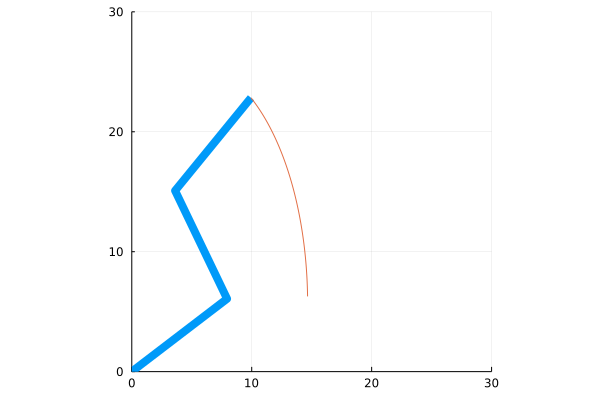

In [30]:
plt = plot(legend=false,xlim=(0,3),ylim=(0,3),aspect_ratio=:equal)
display(plt)
for i = 1:N
    IJulia.clear_output(true)
    x1,x2,x3,y1,y2,y3 = arm(q1[i],q2[i],q3[i])
    l1 = [0,x1,x2,x3]
    l2 = [0,y1,y2,y3]
    plt = plot(l1,l2, legend=false,xlim=(0,30),ylim=(0,30), linewidth=8, aspect_ratio=:equal)
    plot!(p1[1:i],p2[1:i])
    display(plt)
    sleep(.02)
end